In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest, SelectPercentile
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import validation_curve, cross_val_score, learning_curve, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.svm import SVC
import warnings
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import ShuffleSplit


warnings.filterwarnings("ignore", category=FutureWarning)

# Coding Challenge
## Objective: improve performance
### Benchmark: https://triamus.github.io/project/lending-club-loan-data-in-r/#loan-amount-and-income

Some steps with preprocessing data was skipped, due to time constraint. The project is mainly supposed to show the improvement of the performance

# 1. First Steps

<li> Load Data 
<li> Use algorithm/ techinques to intelligently remove rest of the features

## Load Data

In [2]:
dat = np.load("data.npz",allow_pickle=True)
values = dat["arr_0"]
header = dat["arr_1"]
dt = pd.DataFrame(values,columns = header)

# Feature Selection 

Problem of using all variables? Overfitting. Instead of handpicking variables, I'll try to use an algorithm to pick "right" features.
<br>
Options:
<li> Forward Selection
<li> Backward Selection
<li> Mutual Information Classification
<br>
Due to computing capacity and a sizable dataset, I'll use Mutual Information Classification to pick up first 30 and then Forward Selection to get 10 "best" features. In that way I will skip features that are correlated to each other.

## Mutual Information Classification

Given variables $X$ and $Y$, Mutual information (MI) measures the information that $X$ and $Y$ share. We will first calculate MI for each variable and pick up "top" 40 features.

NOTE: On my computer this section run for over 2 hours. I uploaded parameters that can be loaded directly. To save time proceed to next section to load parameters.

In [3]:
X = dt.drop("loan_status", axis=1)
y = dt["loan_status"]

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
mutual_info = mutual_info_classif(x_train, y_train)

In [48]:
# load if needed
#mi_series.to_pickle("./mutual.pkl")
mi_series = pd.read_pickle("./mutual.pkl")

In [6]:
mi_series = pd.Series(mutual_info)
mi_series.index = X.columns
mi_series.sort_values(ascending=False)

total_rec_prncp                        0.517290
last_pymnt_amnt                        0.329466
recoveries                             0.240537
collection_recovery_fee                0.226519
sec_app_mths_since_last_major_derog    0.175161
NO_HARDSHIP                            0.150645
application_type                       0.143224
mths_since_last_record                 0.125313
term                                   0.107443
total_pymnt                            0.100328
total_pymnt_inv                        0.097138
mths_since_last_major_derog            0.083172
mths_since_rcnt_il                     0.072675
grade                                  0.070808
last_credit_pull_d                     0.066234
initial_list_status                    0.051245
debt_consolidation                     0.050620
mths_since_last_delinq                 0.050366
int_rate                               0.043875
MORTGAGE                               0.040710
out_prncp                              0

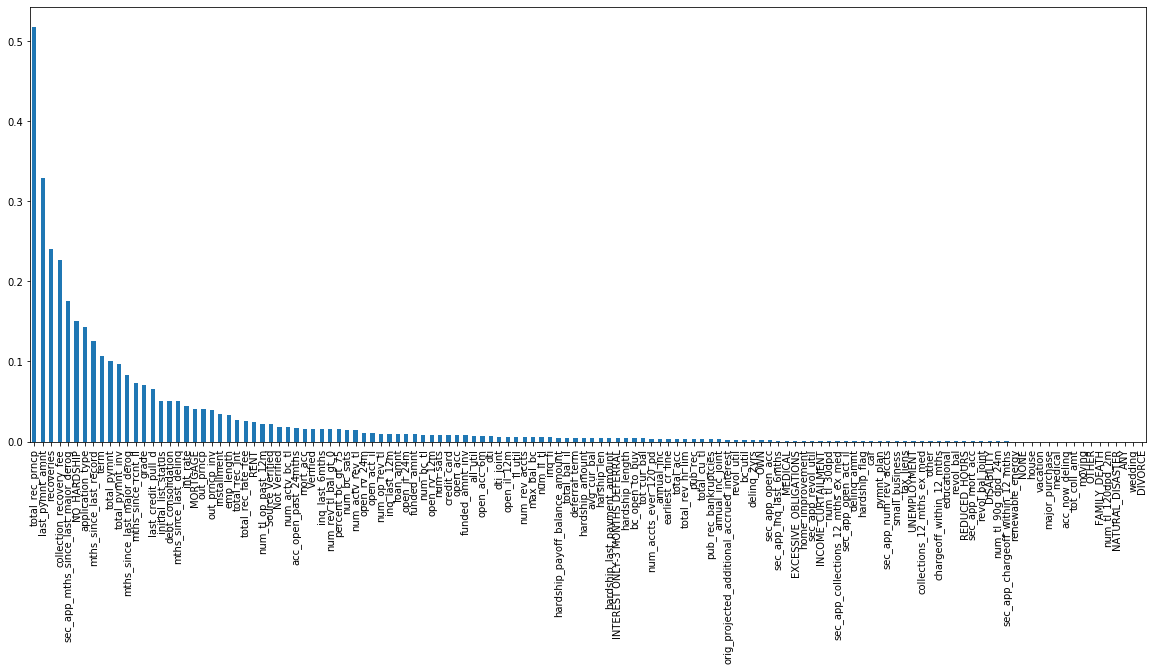

In [7]:
mi_series.sort_values(ascending=False).plot.bar(figsize=(20,8))
plt.show()

In [9]:
# If saved parameters exist, load. Else, run function for best features 
k_best_features = SelectKBest(mutual_info_classif, k=30).fit(x_train, y_train)

In [10]:
print('Selected top 30 features: {}'.format(x_train.columns[k_best_features.get_support()]))

Selected top 30 features: Index(['term', 'int_rate', 'installment', 'grade', 'emp_length',
       'mths_since_last_delinq', 'mths_since_last_record',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_credit_pull_d', 'mths_since_last_major_derog',
       'application_type', 'mths_since_rcnt_il', 'num_tl_op_past_12m',
       'sec_app_mths_since_last_major_derog', 'Not Verified',
       'Source Verified', 'debt_consolidation', 'MORTGAGE', 'RENT',
       'NO_HARDSHIP'],
      dtype='object')


In [11]:
columns_mutual_information = x_train.columns[k_best_features.get_support()]

In [56]:
# load if needed
np.savez("mutual_top.npz", np.array(columns_mutual_information), header)
columns_mutual_information = np.load("mutual_top.npz",allow_pickle=True)
columns_mutual_information = columns_mutual_information["arr_0"]

In [12]:
X = X[columns_mutual_information]

In [13]:
columns_mutual_information

Index(['term', 'int_rate', 'installment', 'grade', 'emp_length',
       'mths_since_last_delinq', 'mths_since_last_record',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_credit_pull_d', 'mths_since_last_major_derog',
       'application_type', 'mths_since_rcnt_il', 'num_tl_op_past_12m',
       'sec_app_mths_since_last_major_derog', 'Not Verified',
       'Source Verified', 'debt_consolidation', 'MORTGAGE', 'RENT',
       'NO_HARDSHIP'],
      dtype='object')

# Using Left Features Use Forward Selection to pick up 12 variables

I will use a Forward Looking Algorithm using a simple logistic regression

In [14]:
logisticRegr = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_forward = X_train[columns_mutual_information]
X_forward_test = X_test[columns_mutual_information]

sfs1 = SFS(logisticRegr,
           k_features=15,
           forward=True,
           floating=False,
           verbose=2,
           scoring='recall',
           cv=5,
           n_jobs=-1)

mu_col = sfs1.fit(X_forward_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   31.7s finished

[2019-08-16 02:15:13] Features: 1/15 -- score: 0.5862724661431761[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   47.5s finished

[2019-08-16 02:16:00] Features: 2/15 -- score: 0.7004534576953725[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   47.8s finished

[2019-08-16 02:16:48] Features: 3/15 -- score: 0.7286410937642669[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   58.7s finished

[2019-08-16 02:17:47] Features: 4/15 -- score: 0.8685868290305369[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.2min finished



In [15]:
columns_forward = list(sfs1.subsets_[10]['feature_names'])
print(columns_forward)
X = X[columns_forward]

['int_rate', 'installment', 'grade', 'out_prncp', 'total_pymnt_inv', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_credit_pull_d', 'Source Verified']


In [84]:
np.savez("top_col_15.npz", list(sfs1.subsets_[15]['feature_names']), header)

In [83]:
# load if needed
forward_save = list(sfs1.subsets_[10]['feature_names'])
np.savez("top_col.npz", np.array(forward_save), header)
forward_save = np.load("top_col.npz",allow_pickle=True)
columns_forward = forward_save["arr_0"][0:11]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)

# Part 6: Try with new variable set
First, I will use the new parameters with a simple logisti regression, then I will experiement around with SVM. Finally, the plan is to set up a small neural network.

In [17]:
logisticRegr = LogisticRegression(random_state = 0)
logisticRegr.fit(X_train_scale, y_train)
predictions = logisticRegr.predict(X_test_scale)

print("F1: " + str(metrics.f1_score(y_test, predictions)))
print("Accuracy: " + str(metrics.accuracy_score(y_test, predictions)))
print("Precision: " + str(metrics.precision_score(y_test, predictions)))
print("Recall: " + str(metrics.recall_score(y_test, predictions)))
print("ROC: " + str(metrics.roc_auc_score(y_test, predictions)))

F1: 0.9448280729822249
Accuracy: 0.9766835449960352
Precision: 0.9922539039335837
Recall: 0.9017289772089367
ROC: 0.949863597859595


# Regularization

In [18]:
logisticRegr = LogisticRegression(penalty='l2', random_state = 0, C=100)
logisticRegr.fit(X_train_scale, y_train)
predictions = logisticRegr.predict(X_test_scale)

print("F1: " + str(metrics.f1_score(y_test, predictions)))
print("Accuracy: " + str(metrics.accuracy_score(y_test, predictions)))
print("Precision: " + str(metrics.precision_score(y_test, predictions)))
print("Recall: " + str(metrics.recall_score(y_test, predictions)))

F1: 0.9406089840217065
Accuracy: 0.9750255412127042
Precision: 0.9932956290497772
Recall: 0.8932300437857864


In [19]:
print(metrics.confusion_matrix(y_test, predictions))

[[312684    537]
 [  9510  79560]]


# CV

In [21]:
# Using CV
classifier = LogisticRegression()
f1 = cross_val_score(classifier, X_train_scale, y_train, cv=5, scoring='f1', verbose=1, n_jobs=-1)

recall = cross_val_score(classifier, X_train_scale, y_train, cv=5, scoring='recall', verbose=1, n_jobs=-1)
accuracy = cross_val_score(classifier, X_train_scale, y_train, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
scores = cross_val_score(classifier, X_train_scale, y_train, cv=5, scoring='precision', verbose=1, n_jobs=-1)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.1s finished


In [24]:
print('F1 ' + str(np.mean(f1)))
print('Accuracy ' + str(np.mean(scores)))
print('Precision ' + str(np.mean(scores)))
print('Recall ' + str(np.mean(recall)))


F1 0.9469026859176392
Accuracy 0.9926027880400567
Precision 0.9926027880400567
Recall 0.9052283540588855


# Learning Curves

In [66]:
train_size = np.arange(0.2, 1, 0.1)

train_sizes, train_scores, test_scores = learning_curve(estimator = LogisticRegression(),
                                                        X = X_train_scale,
                                                        y = y_train,
                                                        train_sizes = train_size, 
                                                        cv = 5,
                                                        scoring = 'neg_mean_squared_error',
                                                        n_jobs= -1)

print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) 
print('\nValidation scores:\n\n', test_scores)

Training scores:

 [[-0.22112952 -0.22307375 -0.22307375 -0.22307375 -0.22307375]
 [-0.22221039 -0.22221039 -0.22243677 -0.22243677 -0.22243677]
 [-0.22239127 -0.22239127 -0.2217554  -0.2217554  -0.2217554 ]
 [-0.22169548 -0.22169548 -0.22188723 -0.22199377 -0.22199377]
 [-0.22146465 -0.22146465 -0.22146687 -0.22220595 -0.22220595]
 [-0.22153758 -0.22153758 -0.22153948 -0.22187049 -0.22187049]
 [-0.22166884 -0.22166884 -0.22166884 -0.22166884 -0.22174708]
 [-0.22175318 -0.22175318 -0.22175466 -0.22175466 -0.22171027]]

 ----------------------------------------------------------------------

Validation scores:

 [[-0.22188605 -0.22188605 -0.22188191 -0.22188191 -0.22188191]
 [-0.22188605 -0.22188605 -0.22188191 -0.22188191 -0.22188191]
 [-0.22188605 -0.22188605 -0.22188191 -0.22188191 -0.22188191]
 [-0.22188605 -0.22188605 -0.22188191 -0.22188191 -0.22188191]
 [-0.22188605 -0.22188605 -0.22188191 -0.22188191 -0.22188191]
 [-0.22188605 -0.22188605 -0.22188191 -0.22188191 -0.22188191]
 [-

# Regularization

In [29]:
lr = LogisticRegression(penalty='l2', random_state = 0)

C_param_range = [0.05, 0.1, 1, 1.5, 2]

train_scores, test_scores = validation_curve(estimator=lr,
                                             X=X_train_scale,
                                             y=y_train,
                                             param_name='C',
                                             param_range=C_param_range,
                                             cv=5,
                                             scoring="roc_auc",
                                             n_jobs=-1)


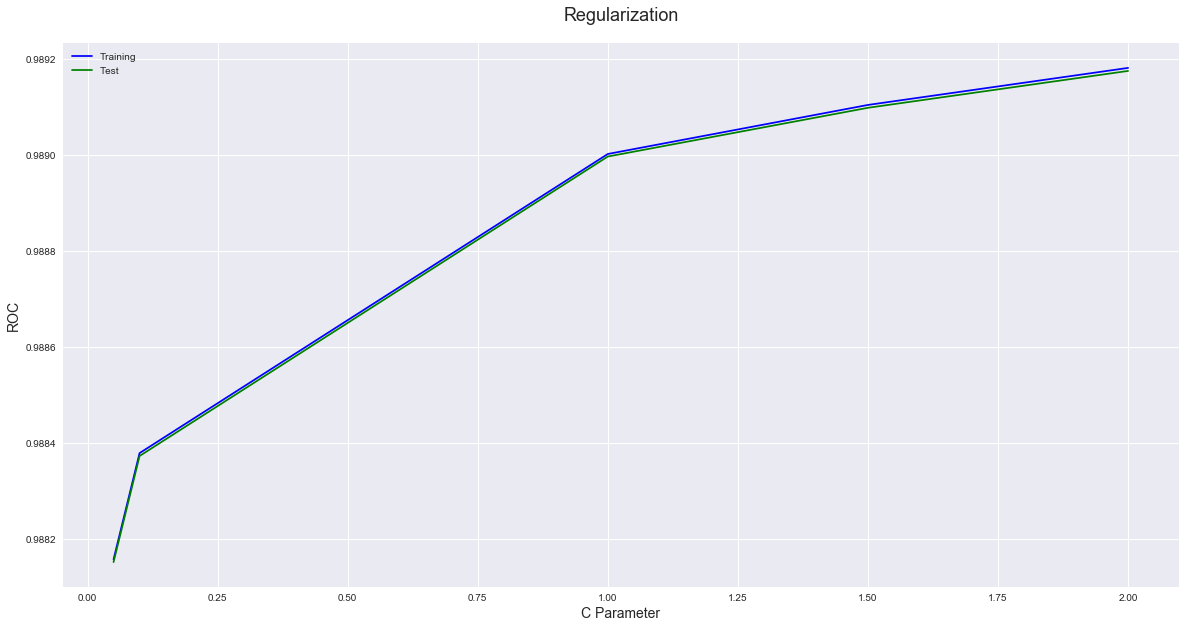

In [30]:
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.figure(figsize=(20,10))
plt.style.use('seaborn')
plt.plot(C_param_range, train_mean, color='blue', label='Training')
plt.plot(C_param_range, test_mean, color='green', label='Test')
plt.ylabel('ROC', fontsize = 14)
plt.xlabel('C Parameter', fontsize = 14)
plt.title('Regularization', fontsize = 18, y = 1.03)
plt.legend()
#plt.ylim(0.8,1)
plt.show()

# 1st Conclusion

Tasks done:
1. Picked variables on Mutual Information
2. Picked variables left with forward search algorithm
3. Logistic Regression model
4. Logistic Regression with regularization (validation curve)

Conclusion:
1. Picking up right variables increased accuracy, precision , and recall
2. Learning Curve shows convergence
3. Validation curve shows no variance bias

# Random Forest

In [31]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
metrics.confusion_matrix(y_test, predictions)

array([[312711,    510],
       [  3463,  85607]])

### Consider

n_estimators = number of trees in the foreset <br>
max_features = max number of features considered for splitting a node<br>
max_depth = max number of levels in each decision tree<br>
min_samples_split = min number of data points placed in a node before the node is split<br>
min_samples_leaf = min number of data points allowed in a leaf node<br>
bootstrap = method for sampling data points (with or without replacement)<br>


# Use Randomized Grid Search to find "better" parameters

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [33]:
# Maximum depth
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [0.01, 0.05, 0.1, 0.15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [0.0001, 0.001, 0.01, 0.004]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [34]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [35]:
rf = RandomForestClassifier(n_estimators=100)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter = 100, cv = 3, verbose=2, random_state=42, 
                               n_jobs=-1, return_train_score=True)

In [36]:
X_train.shape
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 74.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 278.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 572.3min finished


{'n_estimators': 500, 'min_samples_split': 0.01, 'min_samples_leaf': 0.0001, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}


In [85]:
clf=RandomForestClassifier(n_estimators = 500,
                           max_features = 'log2',
                           max_depth = 20,
                           min_samples_split = 0.05,
                           min_samples_leaf = 0.0001,
                           bootstrap= False)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
metrics.confusion_matrix(y_test, predictions)

array([[313170,    365],
       [ 13204,  75552]])

In [86]:
print("F1: " + str(metrics.f1_score(y_test, predictions)))
print("Accuracy: " + str(metrics.accuracy_score(y_test, predictions)))
print("Precision: " + str(metrics.precision_score(y_test, predictions)))
print("Recall: " + str(metrics.recall_score(y_test, predictions)))
print("ROC: " + str(metrics.roc_auc_score(y_test, predictions)))

F1: 0.9176003352097793
Accuracy: 0.9662706846536463
Precision: 0.9951921177074964
Recall: 0.8512325927261255
ROC: 0.9250342241861128
